In [ ]:
!pip install torchvision
!pip install sagemaker

### Import stuff

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim

from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import torch.nn as nn
import pathlib

import random

### load data from S3 to folder of sagemaker instance

In [41]:
import boto3

# When running on SageMaker, need execution role
from sagemaker import get_execution_role
role = get_execution_role()

# Declare bucket name, remote file, and destination
s3_bucket = "amazon-braket-a79a20b5e0b4"
orig_file = 'defect_data.zip'
dest_file = './defect_data.zip'

# Connect to S3 bucket and download file
s3 = boto3.resource('s3')
s3.Bucket(s3_bucket).download_file(orig_file, dest_file)

### unzip defect_data.zip 

In [ ]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
with ZipFile('defect_data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('./defect_data')

### Data preparation 

In [2]:
def get_train_test_data(img_path, img_set_size = 40e3, test_set_ratio = 0.2):
    """
    Create train and test data with PyTorchs ImageFolder class.  
    """

    resolution = (227,227)
    
    img_dataset = datasets.ImageFolder(
        root=img_path,
        transform=transforms.Compose([
            transforms.Resize(resolution), # do not have to resize because all imgs are on 227x227
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
        ]))
    
    # restrict size of data set
    # take n random indices out of full img_dataset size
    random_indices = random.sample(range(len(img_dataset)), img_set_size)

    img_dataset_subset = torch.utils.data.Subset(img_dataset, random_indices)
    
    # split data set into train and test set
    test_set_size = int(test_set_ratio * len(img_dataset_subset))
    train_set_size = len(img_dataset_subset) - test_set_size   
    train_set, test_set = random_split(img_dataset_subset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(42))
    
    # with attribute class_to_idx we get a mapping from classes to labels. We invert the dict subsequently.
    label_to_class_dict = {value: key for key, value in img_dataset.class_to_idx.items()}

    return train_set, test_set, label_to_class_dict

### load data set

In [3]:
img_path = './defect_data'
train_set, test_set, label_to_class_dict = get_train_test_data(img_path, img_set_size = 1000)


BATCH_SIZE = 32

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [4]:
len(train_set)

800

In [5]:
len(test_set)

200

### train functions

In [6]:
def get_plain_accuracy(y_pred, y_true):
    return (y_pred.argmax(dim=1) == y_true).float().mean()

def eval_test_set(model, best_loss, model_name, run_idx):
    print("### Eval test set ###")

    model.eval()

    loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')    
        
    y_test_pred = torch.tensor([]).float()
    y_test_true = torch.tensor([]).long()  
    
    start_time = time.time()
    
    # forward pass is faster with torch.no_grad()
    with torch.no_grad(): 
            
        for x_test_batch, y_test_true_batch in test_loader:
            
            y_test_pred_batch = model(x_test_batch)
            
            y_test_pred = torch.cat([y_test_pred, y_test_pred_batch])
            y_test_true = torch.cat([y_test_true, y_test_true_batch])     

    loss_test = loss_fn(y_test_pred, y_test_true)

    acc_test = get_plain_accuracy(y_test_pred, y_test_true)

    print(f"Loss test: {loss_test:.3f}")
    print(f"Accuracy test: {acc_test:.3f}") 
    print(f'Time {(time.time() - start_time):.2f}')

    # save best_model
    if loss_test < best_loss:
        state = {
            'state_dict': model.state_dict()
        }
        torch.save(state, f'./models/{model_name}_best_model_run_{run_idx}.h5')
        best_loss = loss_test
        
    print("#####################\n")    
    return best_loss, loss_test, acc_test  


def train(model, num_epochs, run_idx, model_name="resnet"):
    """Train function"""
    

    # define loss and optimizer
    loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')
    optimizer = optim.Adam(model.parameters())
    
    acc_train_list = []
    loss_train_list = []    
    
    acc_test_list = []    
    loss_test_list = []   
    
    best_loss = 10e3
    
    for epoch in range(num_epochs):

        print(f'### Epoch {epoch} ###\n')

        for idx, (x_train, y_true) in enumerate(train_loader):

            model.train()
            
            start_time = time.time()
            
            print(f'Batch iter/total {idx}/{len(train_loader)-1}')
            # zero the gradients
            optimizer.zero_grad()

            # do one forward pass
            y_pred = model(x_train)   
                            
            loss = loss_fn(y_pred, y_true)           
                
            acc_train = get_plain_accuracy(y_pred, y_true)

            print(f"Loss train: {loss:.3f}")
            print(f"Accuracy train: {acc_train:.3f}")
                
            # get gradients with respect to that loss
            loss.backward()    
                       
            # actual optimizing step
            optimizer.step()

            acc_train_list.append(acc_train.item())
            loss_train_list.append(loss.item())
            
            print(f'Time per batch_iter {(time.time() - start_time):.2f}\n')
        
            # eval test set every 5 iters
            if ((idx + 1) % 5) == 0:
                best_loss, loss_test, acc_test = eval_test_set(model, best_loss, model_name,run_idx)
                
                acc_test_list.append(acc_test.item())
                loss_test_list.append(loss_test.item())
                
    return acc_train_list, acc_test_list, loss_train_list, loss_test_list


def plot_stuff(data_, title, plot_each_metric=False):
    
    data = data_.mean(axis=0)
    std = data_.std(axis=0)
    
    plt.figure(figsize=(9,5))
    plt.title(title)
    plt.plot(data)
    
    if plot_each_metric:
        plt.plot(data_.T)
    
    plt.fill_between(range(len(data)), data - std, data + std, color='tab:blue', alpha=0.15)
                 
    plt.grid()
    plt.show()

### load pretrained resnet 18 and freeze all conv layers

In [7]:

def run_experiment(num_runs, num_epochs, nn_type, q_depth=None):
    # start training process and measure time duration
    start_time = time.time()

    avg_acc_train = np.array([])
    avg_acc_test = np.array([])

    avg_loss_train = np.array([])
    avg_loss_test = np.array([])

    for run_idx in range(num_runs):

        # load on ImageNet pretrained resnet18
        model = models.resnet18(pretrained=True)

        # freeze all layers
        for name, param in model.named_parameters():
            param.requires_grad = False

        # attach new last classic or quantum layer
        if nn_type == 'classic':
            model.fc = nn.Linear(512, 2)  
            model_name="resnet"
            
        elif nn_type == 'angular':
            model.fc = QuantumNetAngularEmbedding(n_qubits=4, q_depth=q_depth)
            model_name=f"resnet_q_angular_depth{q_depth}"
            
        elif nn_type == 'amplitude':
            model.fc = QuantumNetAmplitudeEmbedding(n_qubits=9, q_depth=q_depth)
            model_name=f"resnet_q_amplitude_depth{q_depth}"    
            
        if  run_idx == 0:  
            print(f'########## {model_name} ##########')
            
        print(f'\n########## run {run_idx} ##########\n')

        acc_train, acc_test, loss_train, loss_test = train(model=model, num_epochs = num_epochs, run_idx= run_idx,model_name=model_name)

        avg_acc_train = np.vstack([avg_acc_train, np.array(acc_train)]) if avg_acc_train.size else np.array(acc_train)  
        avg_acc_test = np.vstack([avg_acc_test, np.array(acc_test)]) if avg_acc_test.size else np.array(acc_test)  

        avg_loss_train = np.vstack([avg_loss_train, np.array(loss_train)]) if avg_loss_train.size else np.array(loss_train)  
        avg_loss_test = np.vstack([avg_loss_test, np.array(loss_test)]) if avg_loss_test.size else np.array(loss_test)        

    total_time = time.time() - start_time

    print(f'total time taken {total_time:.2f}\n')
    
    
    # create folder if not exists
    pathlib.Path(f"./metrics/{model_name}").mkdir(parents=True, exist_ok=True)
    
    # store metrics
    np.save(f'./metrics/{model_name}/avg_acc_test.npy', avg_acc_test)
    np.save(f'./metrics/{model_name}/avg_acc_train.npy', avg_acc_train)

    np.save(f'./metrics/{model_name}/avg_loss_train.npy', avg_loss_train)
    np.save(f'./metrics/{model_name}/avg_loss_test.npy', avg_loss_test)
    
    return avg_acc_train.T, avg_acc_test.T, avg_loss_train.T, avg_loss_test.T
    
    

## Train CNN classically

In [20]:
num_runs = 3
num_epochs = 3

In [21]:
# 
avg_acc_train, avg_acc_test, avg_loss_train, avg_loss_test = run_experiment(num_runs, num_epochs, nn_type='classic')

########## resnet ##########

########## run 0 ##########

### Epoch 0 ###

Batch iter/total 0/24
Loss train: 0.689
Accuracy train: 0.594
Time per batch_iter 0.28

Batch iter/total 1/24
Loss train: 0.819
Accuracy train: 0.438
Time per batch_iter 0.26

Batch iter/total 2/24
Loss train: 0.652
Accuracy train: 0.594
Time per batch_iter 0.25

Batch iter/total 3/24
Loss train: 0.614
Accuracy train: 0.656
Time per batch_iter 0.25

Batch iter/total 4/24
Loss train: 0.625
Accuracy train: 0.719
Time per batch_iter 0.26

### Eval test set ###
Loss test: 0.674
Accuracy test: 0.545
Time 2.16
#####################

Batch iter/total 5/24
Loss train: 0.582
Accuracy train: 0.719
Time per batch_iter 0.25

Batch iter/total 6/24
Loss train: 0.524
Accuracy train: 0.906
Time per batch_iter 0.25

Batch iter/total 7/24
Loss train: 0.593
Accuracy train: 0.656
Time per batch_iter 0.25

Batch iter/total 8/24
Loss train: 0.559
Accuracy train: 0.719
Time per batch_iter 0.24

Batch iter/total 9/24
Loss train: 0.545

max average test accuracy 0.980


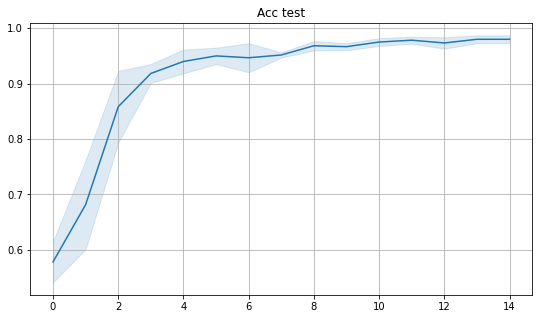

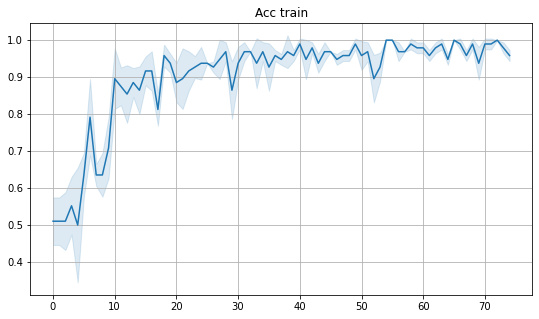

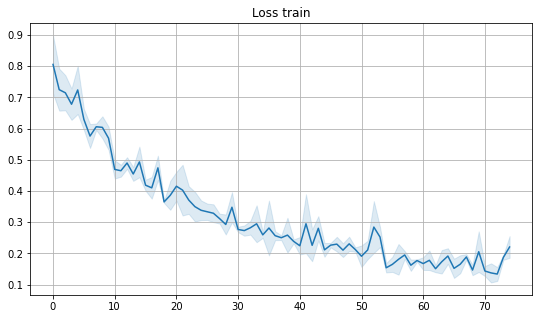

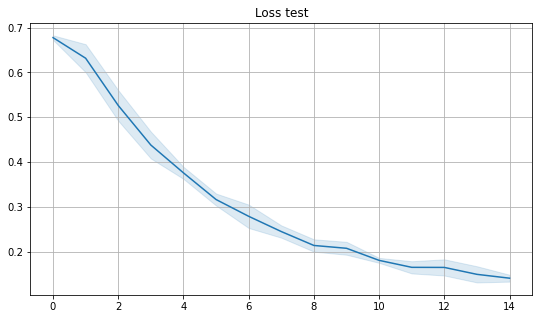

In [22]:

avg_acc_test = np.load('./metrics/resnet/avg_acc_test.npy')
avg_acc_train = np.load('./metrics/resnet/avg_acc_train.npy')

avg_loss_train = np.load('./metrics/resnet/avg_loss_train.npy')
avg_loss_test = np.load('./metrics/resnet/avg_loss_test.npy')

print(f'max average test accuracy {max(avg_acc_test.mean(axis=0)):.3f}')

plot_stuff(avg_acc_test, title = 'Acc test')
plot_stuff(avg_acc_train, title = 'Acc train')

plot_stuff(avg_loss_train, title = 'Loss train')
plot_stuff(avg_loss_test, title = 'Loss test')


### Quantum Net 

In [11]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

n_qubits = 4        

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev = qml.device("default.qubit", wires=n_qubits)

In [12]:
def entangling_layer(n_qubits, pattern):
    """pattern in ('chain', 'ring', 'all_to_all')"""
    
    if pattern not in ('chain', 'ring', 'all_to_all', 'random'):
        pattern = 'chain'
    if pattern is not 'random':
        qml.broadcast(qml.CNOT, wires = list(range(n_qubits)), pattern = pattern)
    else:
        q_idx_list = list(range(n_qubits))
        np.random.shuffle(q_idx_list)
        for i in range(n_qubits - 1):
            qml.CNOT(wires = [q_idx_list[i], q_idx_list[i + 1]])
        qml.CNOT(wires = [q_idx_list[-1], q_idx_list[0]])

def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
        
def RX_layer(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)

def amplitude_embedding(q_input_features, n_qubits):
    """Transfers a given input feature into a quantum statevector. 2**9 = 512"""

    
    assert len(q_input_features) == 2**n_qubits, "Input Features must be of dimension 2**n_qubits"
    
    wires_list = list(range(n_qubits))
    
    # TODO: replace equality comparison to one with tolerance
    normalize = not (np.linalg.norm(q_input_features) == 1)
            
    qml.templates.AmplitudeEmbedding(features = q_input_features, 
                                     wires = wires_list, 
                                     normalize = normalize) 
        
@qml.qnode(dev, interface="torch")
def quantum_net(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        RX_layer(q_weights[k])        
        RY_layer(q_weights[k])
        
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        
    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    
    return tuple(exp_vals)




#### draw circuit

In [13]:
q_depth = 1
n_qubits = 4

q_input_features = (torch.rand(n_qubits) * 2 - 1) * np.pi / 2
q_weights_flat = torch.randn(q_depth * n_qubits)

# evaluation of the circuit is necessary to draw the circuit 
result = quantum_net(q_weights_flat, q_input_features)

print(quantum_net.draw())


 0: ──H──RY(-0.215)──RX(-0.249)──RY(-0.249)──╭C──────────╭X──┤ ⟨Z⟩ 
 1: ──H──RY(0.203)───RX(0.587)───RY(0.587)───╰X──╭C──────│───┤ ⟨Z⟩ 
 2: ──H──RY(0.26)────RX(-1.65)───RY(-1.65)───────╰X──╭C──│───┤ ⟨Z⟩ 
 3: ──H──RY(-1.12)───RX(-1.61)───RY(-1.61)───────────╰X──╰C──┤ ⟨Z⟩ 



In [14]:
my_bucket = "amazon-braket-a79a20b5e0b4"  # the name of the bucket
my_prefix = "amplitude-embbing"  # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [15]:
class QuantumNetAngularEmbedding(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self,n_qubits, q_depth):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        init_param_spread = 0.01
        self.q_params = nn.Parameter(init_param_spread * torch.randn(q_depth * n_qubits))
        print('in init self.q_params',self.q_params)
        self.post_net = nn.Linear(n_qubits, 2)
 
    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        
        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        
        for elem in q_in:
            q_out_elem = quantum_net(self.q_params, elem).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)
    


### Train Quantum CNN with angular embedding for different depth sizes

In [17]:
num_runs = 3
num_epochs = 3
n_qubits = 4

for q_depth in [3]:

    q_avg_acc_train, q_avg_acc_test, q_avg_loss_train, q_avg_loss_test = run_experiment(num_runs, num_epochs, nn_type = 'angular', q_depth = q_depth)

in init self.q_params Parameter containing:
tensor([ 0.0130, -0.0032, -0.0025, -0.0011, -0.0013,  0.0017, -0.0039,  0.0165,
        -0.0118,  0.0037,  0.0200, -0.0184], requires_grad=True)
########## resnet_q_angular_depth3 ##########

########## run 0 ##########

### Epoch 0 ###

Batch iter/total 0/24
Loss train: 0.729
Accuracy train: 0.469
Time per batch_iter 4.87

Batch iter/total 1/24
Loss train: 0.660
Accuracy train: 0.594
Time per batch_iter 4.75

Batch iter/total 2/24
Loss train: 0.694
Accuracy train: 0.531
Time per batch_iter 4.82

Batch iter/total 3/24
Loss train: 0.685
Accuracy train: 0.594
Time per batch_iter 4.74

Batch iter/total 4/24
Loss train: 0.652
Accuracy train: 0.656
Time per batch_iter 4.75

### Eval test set ###
Loss test: 0.694
Accuracy test: 0.540
Time 2.95
#####################

Batch iter/total 5/24
Loss train: 0.587
Accuracy train: 0.812
Time per batch_iter 4.75

Batch iter/total 6/24
Loss train: 0.594
Accuracy train: 0.688
Time per batch_iter 4.74

Batch ite

### Plot angular embedding metric development

#### DEPTH 1 ####
max average test accuracy 0.975


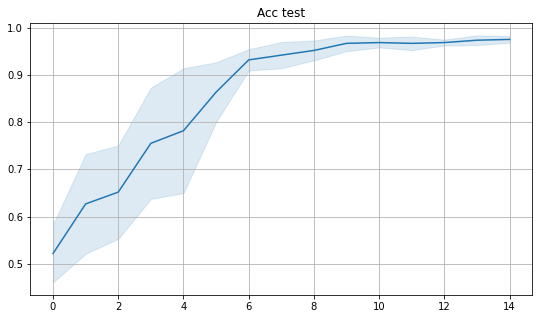

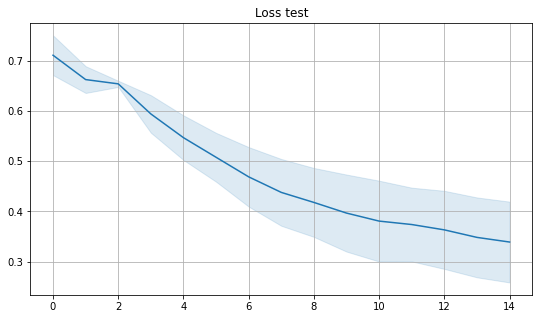

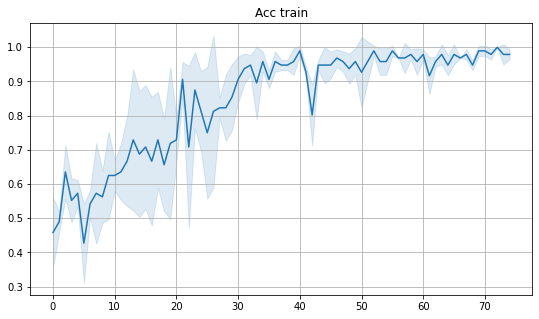

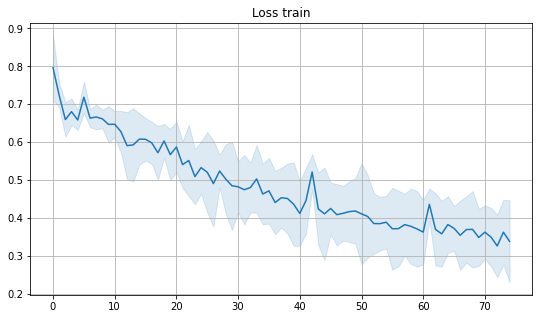

#### DEPTH 3 ####
max average test accuracy 0.988


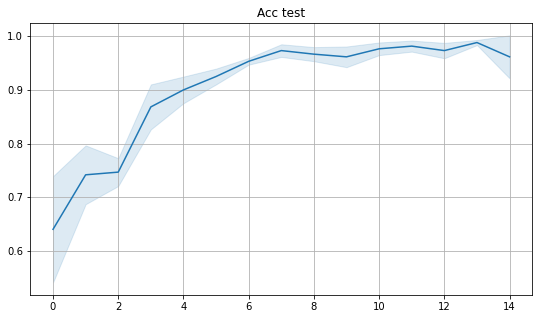

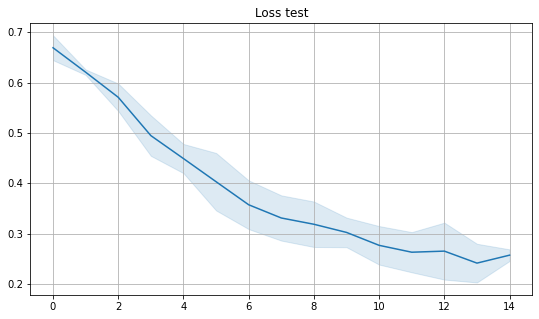

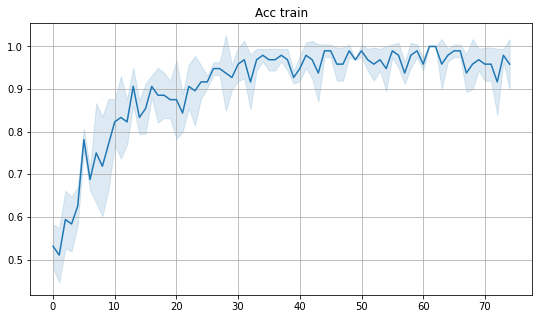

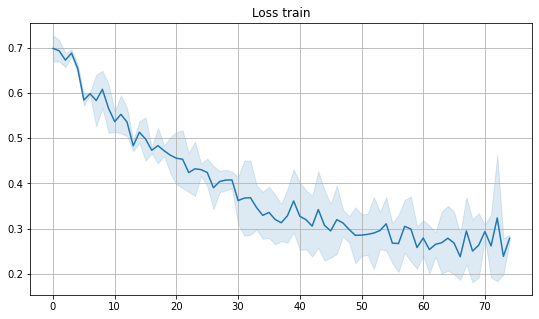

In [23]:

for q_depth in [1, 3]:
    
    model_name=f"resnet_q_angular_depth{q_depth}"
    
    # load quantum metrics
    q_avg_acc_test = np.load(f'./metrics/{model_name}/avg_acc_test.npy')
    q_avg_acc_train = np.load(f'./metrics/{model_name}/avg_acc_train.npy')

    q_avg_loss_train = np.load(f'./metrics/{model_name}/avg_loss_train.npy')
    q_avg_loss_test = np.load(f'./metrics/{model_name}/avg_loss_test.npy')
    
    print(f'#### DEPTH {q_depth} ####')
    
    print(f'max average test accuracy {max(q_avg_acc_test.mean(axis=0)):.3f}')

    plot_stuff(q_avg_acc_test, title = 'Acc test',plot_each_metric=False)
    plot_stuff(q_avg_loss_test, title = 'Loss test',plot_each_metric=False)
    
    plot_stuff(q_avg_acc_train, title = 'Acc train',plot_each_metric=False)
    plot_stuff(q_avg_loss_train, title = 'Loss train',plot_each_metric=False)




### Plot angular embedding vs classic

########## resnet_q_angular_depth1 ##########
########## resnet_q_angular_depth3 ##########


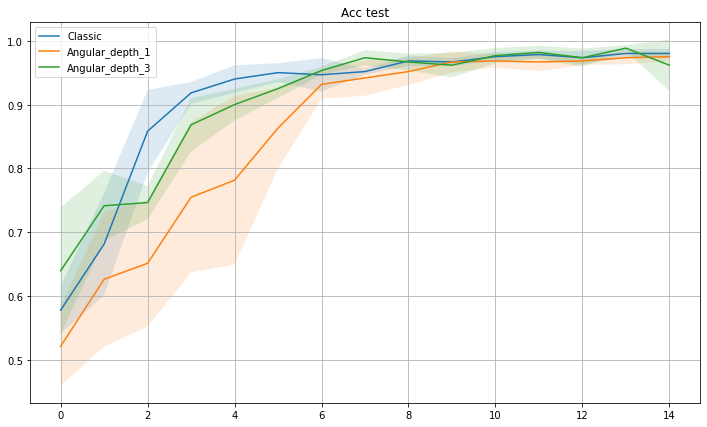

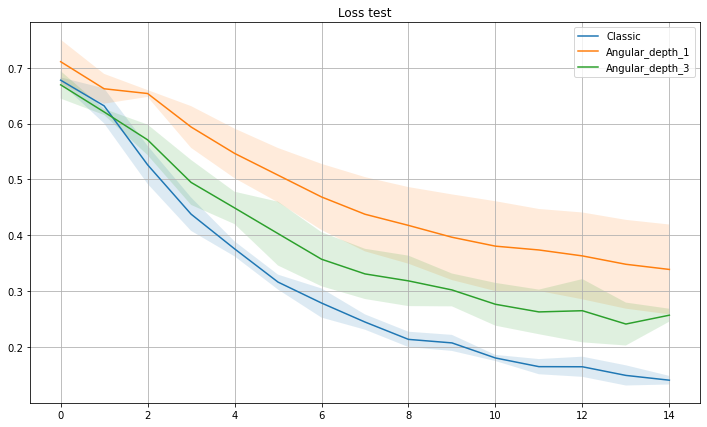

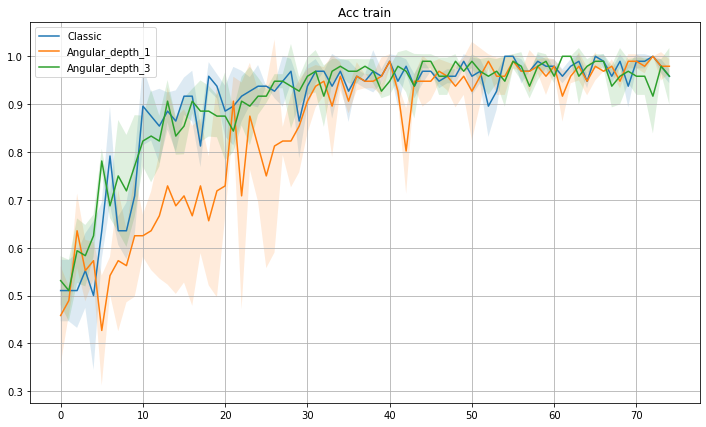

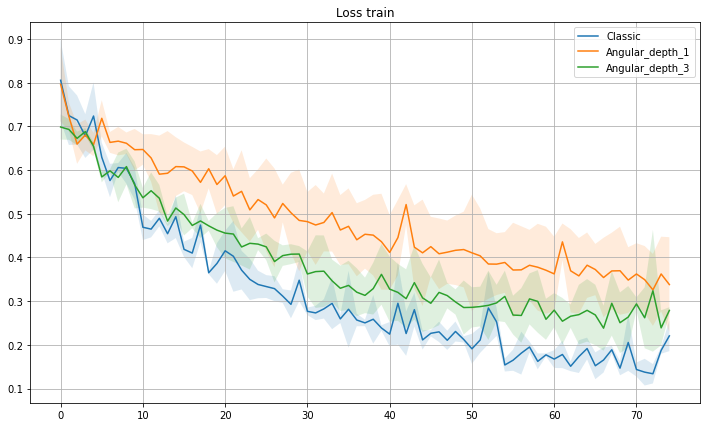

In [32]:
def plot_stuff_combined(data_list, labels_list, title, img_path =None):
    
    plt.figure(figsize=(12,7))
    for idx, data_ in enumerate(data_list):

        data = data_.mean(axis=0)
        std = data_.std(axis=0)

        plt.title(title)

        plt.plot(data, label=labels_list[idx])

        plt.fill_between(range(len(data)), data - std, data + std, alpha=0.15)
        
    plt.legend()
    plt.grid()
    if img_path:
        plt.savefig(img_path)
    plt.show()
    
    
# load classic metrics 
avg_acc_test = np.load('./metrics/resnet/avg_acc_test.npy')
avg_acc_train = np.load('./metrics/resnet/avg_acc_train.npy')

avg_loss_train = np.load('./metrics/resnet/avg_loss_train.npy')
avg_loss_test = np.load('./metrics/resnet/avg_loss_test.npy')

acc_test_list = []
acc_train_list = []

loss_test_list = []
loss_train_list = []

labels_list = []

acc_test_list.append(avg_acc_test)
acc_train_list.append(avg_acc_train)

loss_test_list.append(avg_loss_test)
loss_train_list.append(avg_loss_train)

labels_list.append("Classic")


for q_depth in [1, 3]:
    
    model_name=f"resnet_q_angular_depth{q_depth}"
    
    print(f'########## {model_name} ##########')

    # load quantum metrics
    avg_acc_test = np.load(f'./metrics/{model_name}/avg_acc_test.npy')
    avg_acc_train = np.load(f'./metrics/{model_name}/avg_acc_train.npy')

    avg_loss_train = np.load(f'./metrics/{model_name}/avg_loss_train.npy')
    avg_loss_test = np.load(f'./metrics/{model_name}/avg_loss_test.npy')
    
    acc_test_list.append(avg_acc_test)
    acc_train_list.append(avg_acc_train)

    loss_test_list.append(avg_loss_test)
    loss_train_list.append(avg_loss_train)
    
    labels_list.append(f"Angular_depth_{q_depth}")

# plot in one plot
plot_stuff_combined(acc_test_list, labels_list, title = 'Acc test', img_path ='./plots/acc_angular_classic.jpg')
plot_stuff_combined(loss_test_list, labels_list, title = 'Loss test',img_path ='./plots/loss_angular_classic.jpg')

plot_stuff_combined(acc_train_list, labels_list, title = 'Acc train')
plot_stuff_combined(loss_train_list, labels_list, title = 'Loss train')

### set up quantum net with amplitude embedding

In [63]:
# amplitude embedding 
n_qubits = 9
q_depth = 1

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits, 2)

    amplitude_embedding(q_input_features, n_qubits)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        
        RY_layer(q_weights[k,:, 0])
        RX_layer(q_weights[k,:, 1])       
        
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
    
    # measure last two qubitss
    return tuple([qml.expval(qml.PauliZ(qubit)) for qubit in range(n_qubits - 2, n_qubits)])


q_input_features = torch.randn(2 ** n_qubits,requires_grad=False)
q_weights_flat = torch.randn(q_depth * n_qubits * 2) 

print('q_weights_flat',q_weights_flat)
result = quantum_net_amplitude(q_weights_flat, q_input_features)

print('quantum_net_amplitude.draw()')
print(quantum_net_amplitude.draw())

class QuantumNetAmplitudeEmbedding(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self, n_qubits, q_depth):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        
        self.q_params = nn.Parameter( np.pi * ( torch.rand(q_depth * n_qubits * 2) * 2 - 1) )
        print('in init self.q_params', self.q_params)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, 2)
        q_out = q_out.to(device)
        
        # iterate over each element of the batch
        for elem in input_features:
            q_out_elem = quantum_net_amplitude(self.q_params, elem).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        
        # transform q_out \in [-1,1] to |R
        q_out = torch.arctanh(q_out)
        
        return q_out
    

q_weights_flat tensor([-0.2306, -0.8960,  0.4267, -0.6918, -1.0785,  0.0098,  0.5169,  0.6629,
        -0.7725,  0.1998,  0.5384, -0.4536, -2.2713, -0.9788, -1.5580,  0.2572,
        -1.0505,  0.5416])
quantum_net_amplitude.draw()
 0: ──╭QubitStateVector(M0)──RY(-0.231)──RX(-0.896)───╭C──────────────────────────────╭X──┤     
 1: ──├QubitStateVector(M0)──RY(0.427)───RX(-0.692)───╰X──╭C──────────────────────────│───┤     
 2: ──├QubitStateVector(M0)──RY(-1.08)───RX(0.00979)──────╰X──╭C──────────────────────│───┤     
 3: ──├QubitStateVector(M0)──RY(0.517)───RX(0.663)────────────╰X──╭C──────────────────│───┤     
 4: ──├QubitStateVector(M0)──RY(-0.773)──RX(0.2)──────────────────╰X──╭C──────────────│───┤     
 5: ──├QubitStateVector(M0)──RY(0.538)───RX(-0.454)───────────────────╰X──╭C──────────│───┤     
 6: ──├QubitStateVector(M0)──RY(-2.27)───RX(-0.979)───────────────────────╰X──╭C──────│───┤     
 7: ──├QubitStateVector(M0)──RY(-1.56)───RX(0.257)────────────────────────────╰X──╭C──│───

### Train QNN with amplitude embedding

In [ ]:
num_runs = 3
num_epochs = 3
n_qubits = 9

for q_depth in [1, 3, 5]:

    q_avg_acc_train, q_avg_acc_test, q_avg_loss_train, q_avg_loss_test = run_experiment(num_runs, num_epochs, nn_type = 'amplitude', q_depth = q_depth)

in init self.q_params Parameter containing:
tensor([ 2.6829,  0.8089,  3.1119,  1.5353, -2.4908, -1.3787,  0.6003, -1.4313,
        -1.7272, -1.7275,  2.6575, -0.0796,  1.7549, -3.0907,  0.9303, -1.6096,
         1.2881, -2.3100], requires_grad=True)
########## resnet_q_amplitude_depth1 ##########

########## run 0 ##########

### Epoch 0 ###

Batch iter/total 0/24
Loss train: 0.693
Accuracy train: 0.625
Time per batch_iter 2.55

Batch iter/total 1/24
Loss train: 0.693
Accuracy train: 0.500
Time per batch_iter 2.48

Batch iter/total 2/24
Loss train: 0.694
Accuracy train: 0.438
Time per batch_iter 2.47

Batch iter/total 3/24
Loss train: 0.691
Accuracy train: 0.531
Time per batch_iter 2.53

Batch iter/total 4/24
Loss train: 0.690
Accuracy train: 0.688
Time per batch_iter 2.47

### Eval test set ###
Loss test: 0.695
Accuracy test: 0.440
Time 2.79
#####################

Batch iter/total 5/24
Loss train: 0.694
Accuracy train: 0.469
Time per batch_iter 2.49

Batch iter/total 6/24
Loss train:

### Plot amplitude embedding metric development

#### DEPTH 1 ####
max average test accuracy 0.597


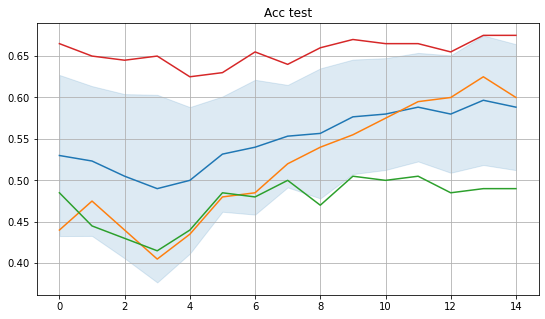

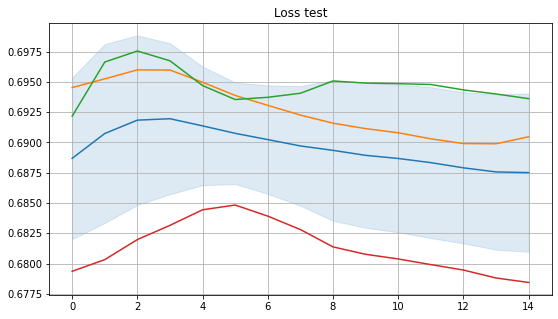

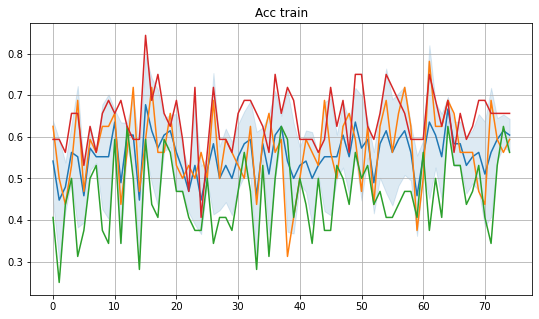

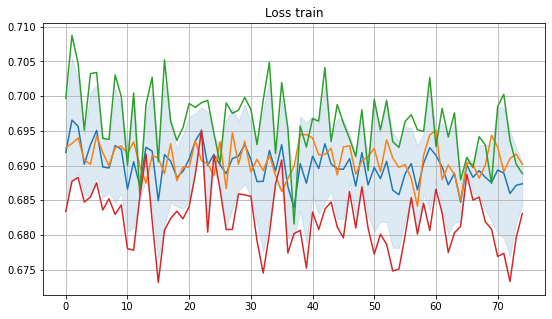

#### DEPTH 3 ####
max average test accuracy 0.643


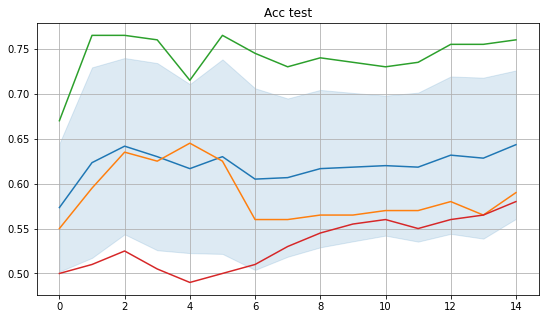

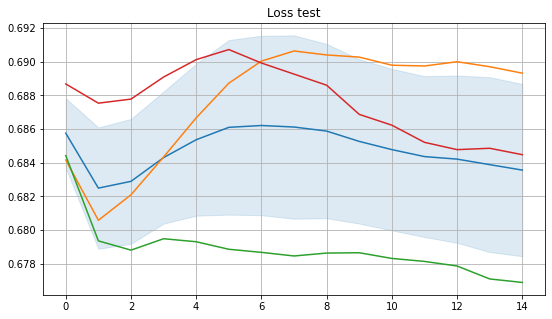

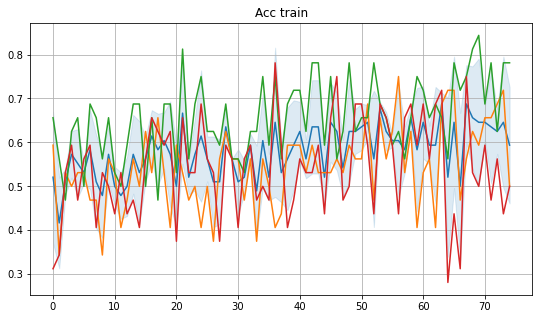

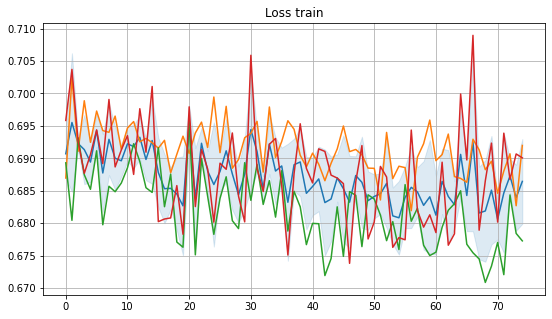

#### DEPTH 5 ####
max average test accuracy 0.757


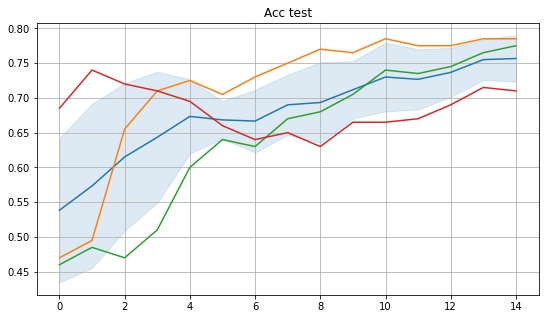

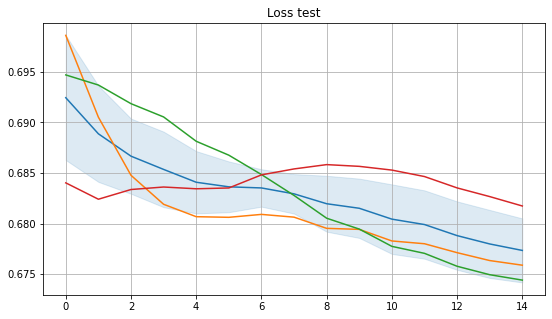

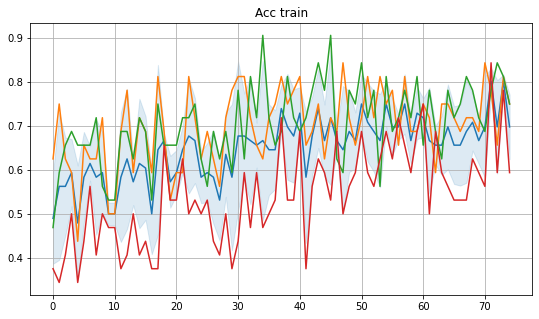

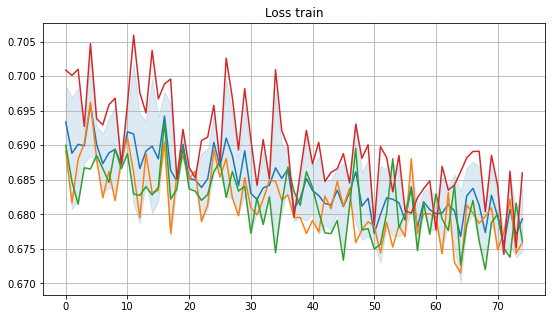

In [25]:


for q_depth in [1, 3 , 5]:
    
    model_name=f"resnet_q_amplitude_depth{q_depth}"
    
    # load quantum metrics
    q_avg_acc_test = np.load(f'./metrics/{model_name}/avg_acc_test.npy')
    q_avg_acc_train = np.load(f'./metrics/{model_name}/avg_acc_train.npy')

    q_avg_loss_train = np.load(f'./metrics/{model_name}/avg_loss_train.npy')
    q_avg_loss_test = np.load(f'./metrics/{model_name}/avg_loss_test.npy')
    
    print(f'#### DEPTH {q_depth} ####')
    
    print(f'max average test accuracy {max(q_avg_acc_test.mean(axis=0)):.3f}')

    plot_stuff(q_avg_acc_test, title = 'Acc test',plot_each_metric=True)
    plot_stuff(q_avg_loss_test, title = 'Loss test',plot_each_metric=True)
    
    plot_stuff(q_avg_acc_train, title = 'Acc train',plot_each_metric=True)
    plot_stuff(q_avg_loss_train, title = 'Loss train',plot_each_metric=True)




### Plot amplitude vs classic

########## resnet_q_amplitude_depth1 ##########
########## resnet_q_amplitude_depth3 ##########


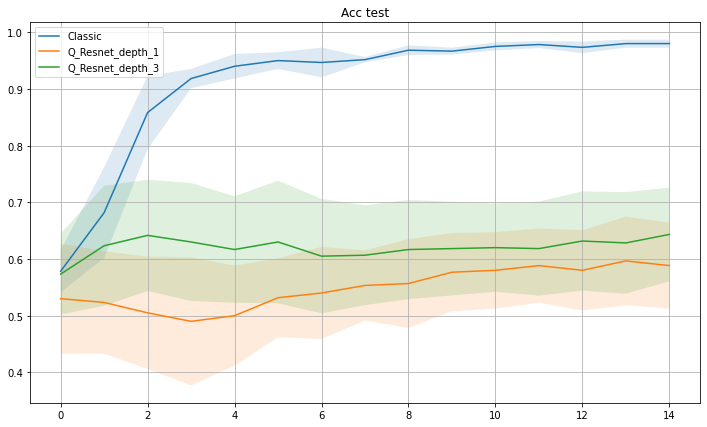

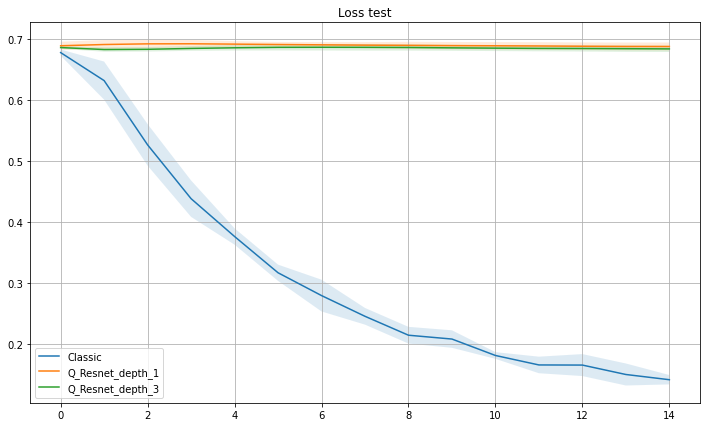

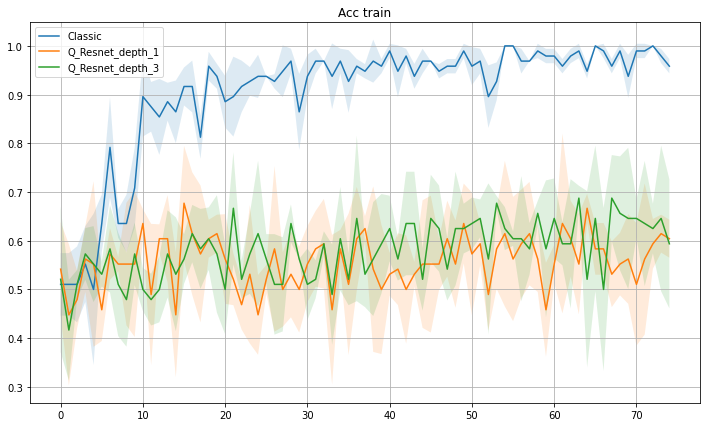

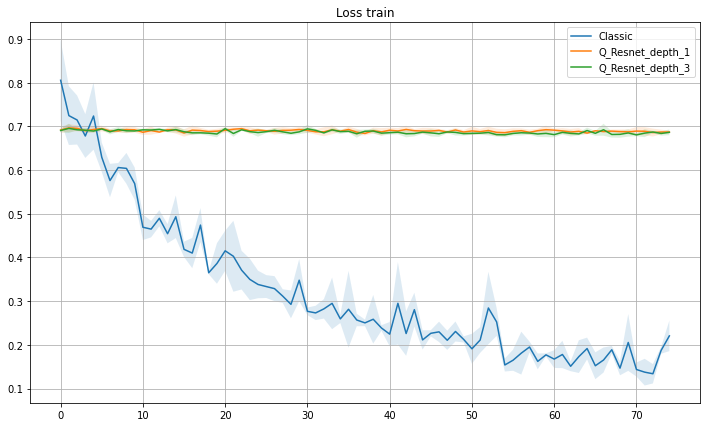

In [30]:
# load classic metrics 
avg_acc_test = np.load('./metrics/resnet/avg_acc_test.npy')
avg_acc_train = np.load('./metrics/resnet/avg_acc_train.npy')

avg_loss_train = np.load('./metrics/resnet/avg_loss_train.npy')
avg_loss_test = np.load('./metrics/resnet/avg_loss_test.npy')

acc_test_list = []
acc_train_list = []

loss_test_list = []
loss_train_list = []

labels_list = []

acc_test_list.append(avg_acc_test)
acc_train_list.append(avg_acc_train)

loss_test_list.append(avg_loss_test)
loss_train_list.append(avg_loss_train)

labels_list.append("Classic")


for q_depth in [1, 3]:
    
    model_name=f"resnet_q_amplitude_depth{q_depth}"
    
    print(f'########## {model_name} ##########')

    # load quantum metrics
    avg_acc_test = np.load(f'./metrics/{model_name}/avg_acc_test.npy')
    avg_acc_train = np.load(f'./metrics/{model_name}/avg_acc_train.npy')

    avg_loss_train = np.load(f'./metrics/{model_name}/avg_loss_train.npy')
    avg_loss_test = np.load(f'./metrics/{model_name}/avg_loss_test.npy')
    
    acc_test_list.append(avg_acc_test)
    acc_train_list.append(avg_acc_train)

    loss_test_list.append(avg_loss_test)
    loss_train_list.append(avg_loss_train)
    
    labels_list.append(f"Amplitde_depth_{q_depth}")

# plot in one plot
plot_stuff_combined(acc_test_list, labels_list, title = 'Acc test', img_path ='./plots/acc_amplitude_classic.jpg')
plot_stuff_combined(loss_test_list, labels_list, title = 'Loss test', img_path ='./plots/loss_amplitude_classic.jpg')

plot_stuff_combined(acc_train_list, labels_list, title = 'Acc train')
plot_stuff_combined(loss_train_list, labels_list, title = 'Loss train')

# Backlog 

## Timing experiments

### evaluate forward backward passes of example circuit

In [ ]:
n_wires = 25

device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=n_wires,
    s3_destination_folder=s3_folder,
    parallel=True,
)

dev_local = qml.device("default.qubit", wires=n_wires)
dev_local_braket = qml.device("braket.local.qubit", wires=n_wires)

In [ ]:
def circuit(params):
    for i in range(n_wires):
        qml.RX(params[i], wires=i)
    for i in range(n_wires):
        qml.CNOT(wires=[i, (i + 1) % n_wires])
    return qml.expval(qml.PauliZ(n_wires - 1))

In [ ]:
qnode_remote = qml.QNode(circuit, dev_remote)
qnode_local = qml.QNode(circuit, dev_local)
qnode_local_braket = qml.QNode(circuit, dev_local)

### forward pass

In [ ]:
import time
n_wires = 25
params = np.random.random(n_wires)

t_0_remote = time.time()
qnode_remote(params)
t_1_remote = time.time()

t_0_local = time.time()
qnode_local(params)
t_1_local = time.time()

t_0_local_braket = time.time()
qnode_local_braket(params)
t_1_local_braket = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)
print("Execution time on local device (seconds):", t_1_local - t_0_local)
print("Execution time on local braket device (seconds):", t_1_local_braket - t_0_local_braket)

### backward

In [ ]:
d_qnode_remote = qml.grad(qnode_remote)

t_0_remote_grad = time.time()
d_qnode_remote(params)
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)

### evaluate quantum net with amplitude embedding

In [ ]:
def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """
    
    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    
    amplitude_embedding(q_input_features, n_qubits)

    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])

    return qml.expval(qml.PauliZ(0))

q_depth = 1
n_wires = 9

qnode_remote = qml.QNode(quantum_net_amplitude, dev_remote)
qnode_local = qml.QNode(quantum_net_amplitude, dev_local)
qnode_local_braket = qml.QNode(quantum_net_amplitude, dev_local_braket)

params = np.random.random(n_wires,requires_grad = True)

q_input_features =  np.random.random(512,requires_grad=False)

result = qnode_remote(q_weights_flat, q_input_features)

print(qnode_remote.draw())

result = qnode_local(q_weights_flat, q_input_features)

print(qnode_local.draw())

result = qnode_local_braket(q_weights_flat, q_input_features)

print(qnode_local_braket.draw())

#### forward pass for quantum net

In [ ]:
import time


t_0_remote = time.time()
qnode_remote(params, q_input_features)
t_1_remote = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)

t_0_local = time.time()
qnode_local(params, q_input_features)
t_1_local = time.time()

print("Execution time on local device (seconds):", t_1_local - t_0_local)

t_0_local_braket = time.time()
qnode_local_braket(params, q_input_features)
t_1_local_braket = time.time()

print("Execution time on local_braket device (seconds):", t_1_local_braket - t_0_local_braket)



#### gradient calculation for quantum net 

In [ ]:
d_qnode_remote = qml.grad(qnode_remote)

t_0_remote_grad = time.time()
d_qnode_remote(params, q_input_features)
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)

d_qnode_local = qml.grad(qnode_local)

t_0_local_grad = time.time()
d_qnode_local(params, q_input_features)
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)

d_qnode_local_braket = qml.grad(qnode_local_braket)

t_0_local_braket_grad = time.time()
d_qnode_local_braket(params, q_input_features)
t_1_local_braket__grad = time.time()

print("Gradient calculation time on local braket device (seconds):", t_1_local_braket__grad - t_0_local_braket_grad)

### quantum net with hadamard instead of amplitude 



In [ ]:
def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """

    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    

#     amplitude_embedding(q_input_features, n_qubits)

#     # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)
    
    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])
        

    return qml.expval(qml.PauliZ(0)) 

In [ ]:
q_depth = 1
n_wires = 9

qnode_remote = qml.QNode(quantum_net_amplitude, dev_remote,)
qnode_local = qml.QNode(quantum_net_amplitude, dev_local)
qnode_local_braket = qml.QNode(quantum_net_amplitude, dev_local_braket)


params = np.random.randn(n_wires, requires_grad=True)
q_input_features = np.random.randn(512, requires_grad=False)

In [ ]:
import time

t_0_remote = time.time()
qnode_remote(params, q_input_features)
t_1_remote = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)

t_0_local = time.time()
qnode_local(params, q_input_features)
t_1_local = time.time()

print("Execution time on local device (seconds):", t_1_local - t_0_local)

t_0_local_braket = time.time()
qnode_local_braket(params, q_input_features)
t_1_local_braket = time.time()

print("Execution time on local_braket device (seconds):", t_1_local_braket - t_0_local_braket)



In [ ]:
d_qnode_remote = qml.grad(qnode_remote)

t_0_remote_grad = time.time()
d_qnode_remote(params, q_input_features)
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)

d_qnode_local = qml.grad(qnode_local)

t_0_local_grad = time.time()
d_qnode_local(params, q_input_features)
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)

d_qnode_local_braket = qml.grad(qnode_local_braket)

t_0_local_braket_grad = time.time()
d_qnode_local_braket(params, q_input_features)
t_1_local_braket__grad = time.time()

print("Gradient calculation time on local braket device (seconds):", t_1_local_braket__grad - t_0_local_braket_grad)

### forward pass with pytorch interface und hadamard gate

In [ ]:


def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """

    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    

#     amplitude_embedding(q_input_features, n_qubits)

#     # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)
    
    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])
        
    return qml.expval(qml.PauliZ(0)) 


qnode_remote = qml.QNode(quantum_net_amplitude, dev_remote, interface='torch')
qnode_local = qml.QNode(quantum_net_amplitude, dev_local, interface='torch')
qnode_local_braket = qml.QNode(quantum_net_amplitude, dev_local_braket, interface='torch')

n_wires = 9
                               
params = torch.randn(n_wires, requires_grad=True)
q_input_features = torch.randn(512, requires_grad=False)
                               
import time

########## FORWARD ##############

t_0_remote = time.time()
result_remote = qnode_remote(params, q_input_features)
t_1_remote = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)

t_0_local = time.time()
result_local = qnode_local(params, q_input_features)
t_1_local = time.time()

print("Execution time on local device (seconds):", t_1_local - t_0_local)

t_0_local_braket = time.time()
result_local_braket = qnode_local_braket(params, q_input_features)
t_1_local_braket = time.time()

print("Execution time on local_braket device (seconds):", t_1_local_braket - t_0_local_braket)

print()
########## BACKWARD ###########

t_0_remote_grad = time.time()
result_remote.backward()
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)
                               
                               
t_0_local_grad = time.time()                               
result_local.backward()  
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)                               

t_0_local_braket_grad = time.time()                               
result_local_braket.backward()    
t_1_local_braket__grad = time.time()                               
print("Gradient calculation time on local braket device (seconds):", t_1_local_braket__grad - t_0_local_braket_grad)

### forward pass with pytorch interface und amplitude embedding

In [ ]:


def quantum_net_amplitude(q_weights_flat, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """

    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    

    amplitude_embedding(q_input_features, n_qubits)

#     # Start from state |+> , unbiased w.r.t. |0> and |1>
#     H_layer(n_qubits)
    
    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')
        RY_layer(q_weights[k])
        
    return qml.expval(qml.PauliZ(0)) 


qnode_remote = qml.QNode(quantum_net_amplitude, dev_remote, interface='torch')
qnode_local = qml.QNode(quantum_net_amplitude, dev_local, interface='torch')
qnode_local_braket = qml.QNode(quantum_net_amplitude, dev_local_braket, interface='torch')

n_wires = 9
                               
params = torch.randn(n_wires, requires_grad=True)
q_input_features = torch.randn(512, requires_grad=False)
                               
import time

########## FORWARD ##############

t_0_remote = time.time()
result_remote = qnode_remote(params, q_input_features)
t_1_remote = time.time()

print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)

t_0_local = time.time()
result_local = qnode_local(params, q_input_features)
t_1_local = time.time()

print("Execution time on local device (seconds):", t_1_local - t_0_local)

t_0_local_braket = time.time()
result_local_braket = qnode_local_braket(params, q_input_features)
t_1_local_braket = time.time()

print("Execution time on local_braket device (seconds):", t_1_local_braket - t_0_local_braket)

print()
########## BACKWARD ###########

t_0_remote_grad = time.time()
result_remote.backward()
t_1_remote_grad = time.time()

print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)
                               
                               
t_0_local_grad = time.time()                               
result_local.backward()  
t_1_local_grad = time.time()

print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)                               

t_0_local_braket_grad = time.time()                               
result_local_braket.backward()    
t_1_local_braket__grad = time.time()                               
print("Gradient calculation time on local braket device (seconds):", t_1_local_braket__grad - t_0_local_braket_grad)

### check different differentiation methods for pytorch with amplitude embedding

In [ ]:
blubb

In [ ]:
n_wires = 2
n_qubits = 2
q_depth = 1

from torch.autograd.functional import jacobian

def entangling_layer(n_qubits = n_qubits, pattern = 'chain'):
    """pattern in ('chain', 'ring', 'all_to_all')"""
    
    if pattern not in ('chain', 'ring', 'all_to_all', 'random'):
        pattern = 'chain'
    if pattern is not 'random':
        qml.broadcast(qml.CNOT, wires = list(range(n_qubits)), pattern = pattern)
    else:
        q_idx_list = list(range(n_qubits))
        np.random.shuffle(q_idx_list)
        for i in range(n_qubits - 1):
            qml.CNOT(wires = [q_idx_list[i], q_idx_list[i + 1]])
        qml.CNOT(wires = [q_idx_list[-1], q_idx_list[0]])
        
q_input_features = torch.randn(2**n_qubits , requires_grad=False)*2        

def quantum_net_amplitude(q_weights_flat):#, q_input_features=None):
    """
    The variational quantum circuit with amplitude embedding
    """

    # Reshape weights
    
    q_weights = q_weights_flat.reshape(q_depth, n_qubits, 2)  
    
    amplitude_embedding(q_input_features, n_qubits)

    # Sequence of trainable variational layers
    start_time = time.time()
    
    for k in range(q_depth):
        RY_layer(q_weights[k,:,0])
        RX_layer(q_weights[k,:,1])
        entangling_layer(n_qubits = n_qubits, pattern = 'ring')

#     return tuple([qml.expval(qml.PauliZ(idx)) for idx in range(n_qubits)])
    return qml.expval(qml.PauliZ(n_qubits-1))


class Blubb(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
 
        self.q_params = nn.Parameter(np.pi / 2 * (torch.rand(n_wires * q_depth * 2, requires_grad=True) * 2 - 1))
        self.qnode_local = qml.QNode(quantum_net_amplitude, dev_local, interface='torch')
        
    def forward(self):
        
        return self.qnode_local(self.q_params)
    




device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=n_wires,
    s3_destination_folder=s3_folder,
    parallel=True,
)

dev_local_braket = qml.device("braket.local.qubit", wires=n_wires)
dev_local = qml.device("default.qubit", wires=n_wires)

diff_method = ["best"]
    
qnode_local = qml.QNode(quantum_net_amplitude, dev_local, interface='torch')

params = np.pi / 2 * (torch.rand(n_wires * q_depth *2 , requires_grad=True) * 2 - 1)
test = qnode_local(params)

import time
print(qnode_local.draw())

########## FORWARD ##############

blubb = Blubb()

optimizer = optim.Adam(blubb.parameters(),lr=0.1)
result_list = []
for iter_ in range(100):
    
    print(f'Iteration {iter_}')
    
    optimizer.zero_grad()

    t_0_local = time.time()
    
    result_local = blubb()
    result_list.append(result_local)
    
    t_1_local = time.time()

    print(result_local.item())

    t_0_local_grad = time.time()                               
    
    result_local.backward() 
    
    print(f'Gradient {blubb.q_params.grad}')
    
    t_1_local_grad = time.time()

    optimizer.step()
    print()
     

In [ ]:
plt.plot(result_list)
plt.show()

In [ ]:
qnode_local = qml.QNode(quantum_net_amplitude, dev_local, interface='torch')

params = np.pi/2*(torch.rand(n_wires * q_depth *2 , requires_grad=True)*2-1)
test = qnode_local(blubb.q_params)
import time
print(qnode_local.draw())

In [ ]:
tensor([-1.0893, -0.2871,  0.7455,  0.9715]